https://colab.research.google.com/drive/1Hh63kIBAiBw3Hho--BvfdUWLu-ysMFF0?usp=sharing

위 코드를 현재 버전에 맞게 수정하고 본 과제에 맞게 변경함

In [ ]:
!pip install emoji==0.6.0
!pip install transformers
!pip install soynlp
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=ca005e68919eda3a57b85bcfe180675ae304f9f2691d4ad8e6dd341e32d0142d
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 17.

In [ ]:
import transformers
import emoji
import soynlp
import pytorch_lightning

In [ ]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [ ]:
args = {
    'random_seed': 42,
    'pretrained_model': 'beomi/KcELECTRA-base',
    'pretrained_tokenizer': '',
    'batch_size': 32,
    'lr': 5e-6,   # 5e-6
    'epochs': 10,
    'max_length': 25,
    'train_data_path': "your path",  # Train Dataset file          # fix
    'val_data_path': "your path",  # Validation Dataset file        # fix
    'test_data_path': "your path", # Test Dataset file              # fix
    'test_mode': False,
    'optimizer': 'AdamW',
    'lr_scheduler': 'exp',
    'fp16': True,
    'tpu_cores': 0,
    'cpu_workers': os.cpu_count(),
}

In [ ]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS

class Model(LightningModule):

    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.training_outputs = []
        self.validation_outputs = []
        self.training_loss = []
        self.validation_loss = []

        self.clsfier = AutoModelForSequenceClassification.from_pretrained(self.hparams.pretrained_model, num_labels=4)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.hparams.pretrained_tokenizer
            if self.hparams.pretrained_tokenizer
            else self.hparams.pretrained_model
        )

    def forward(self, **kwargs):
        return self.clsfier(**kwargs)
    
    def step(self, batch, batch_idx):
        data, labels = batch
        output = self(input_ids=data, labels=labels)

        loss = output.loss
        logits = output.logits

        preds = logits.argmax(dim=-1)

        y_true = list(labels.cpu().numpy())
        y_pred = list(preds.cpu().numpy())

        return {
            'loss': loss,
            'y_true': y_true,
            'y_pred': y_pred
        }
    
    def training_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.training_step_outputs.append(ret)
        return ret
    
    def validation_step(self, batch, batch_idx):
        
        ret = self.step(batch, batch_idx)
        self.validation_step_outputs.append(ret)
        return ret

    def epoch_end(self, outputs, state='train'):
        loss = torch.tensor(0, dtype=torch.float)
        if state=='val': print(outputs)
        for i in outputs:
            loss += i['loss'].cpu().detach()
        loss = loss / len(outputs)

        y_true = []
        y_pred = []
        for i in outputs:
            y_true += i['y_true']
            y_pred += i['y_pred']

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        if state =='train':
          self.training_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.training_loss.append(loss)
        elif state == 'val':
          self.validation_outputs.append({'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})
          self.validation_loss.append(loss)

        self.log(state+'_loss', float(loss), on_epoch=True, prog_bar=True)
        self.log(state+'_acc', acc, on_epoch=True, prog_bar=True)
        self.log(state+'_precision', prec, on_epoch=True, prog_bar=True)
        self.log(state+'_recall', rec, on_epoch=True, prog_bar=True)
        self.log(state+'_f1', f1, on_epoch=True, prog_bar=True)
        print(f'[Epoch {self.trainer.current_epoch} {state.upper()}] Loss: {loss}, Acc: {acc}, Prec: {prec}, Rec: {rec}, F1: {f1}')
        return {'loss': loss}     

    def on_train_epoch_end(self): # fix
        self.epoch_end(self.training_step_outputs, state='train')
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self): # fix
        self.epoch_end(self.validation_step_outputs, state='val')   
        self.validation_step_outputs.clear()

    def configure_optimizers(self):

        optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = ExponentialLR(optimizer, gamma=0.5)
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
        }
    
    def read_data(self, path):
        if path.endswith('xlsx'):
            return pd.read_excel(path)
        elif path.endswith('csv'):
            return pd.read_csv(path)
        elif path.endswith('tsv') or path.endswith('txt'):
            return pd.read_csv(path, sep='\t')
        else:
            raise NotImplementedError('Only Excel(xlsx)/Csv/Tsv(txt) are Supported')
        
    def clean(self, x):
        emojis = ''.join(emoji.UNICODE_EMOJI.keys())
        pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣{emojis}]+')
        url_pattern = re.compile(
            r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x

    def encode(self, x, **kwargs):
        return self.tokenizer.encode(
            self.clean(str(x)),
            padding='max_length',
            max_length = self.hparams.max_length,
            truncation=True,
            **kwargs,
        )
    
    def preprocess_dataframe(self, df):
        df['sentence'] = df['sentence'].map(self.encode)
        return df
    
    def dataloader(self, path, shuffle=False):
        df = self.read_data(path)
        df = self.preprocess_dataframe(df)

        dataset = TensorDataset(
            torch.tensor(df['sentence'].to_list(), dtype=torch.long),
            torch.tensor(df['label'].to_list(), dtype=torch.long)
        )
        return DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 1 if not self.hparams.tpu_cores else self.hparams.tpu_cores,
            shuffle=shuffle,
            num_workers=self.hparams.cpu_workers
        )
    
    def train_dataloader(self):
        return self.dataloader(self.hparams.train_data_path, shuffle=True)
    
    def val_dataloader(self):
        return self.dataloader(self.hparams.val_data_path, shuffle=False)


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename='epoch{epoch}-val_acc{val_acc:.4f}',
    monitor='val_acc',
    save_top_k=3,
    mode='max',
    auto_insert_metric_name=False,
)

In [ ]:
model = Model(**args)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [ ]:
from pytorch_lightning.utilities.model_summary import LayerSummary
summary = LayerSummary(model)
summary.num_parameters

109084420

In [ ]:
print("Using PyTorch Ver", torch.__version__)
print("Fix Seed:", args['random_seed'])
seed_everything(args['random_seed'])
model = Model(**args)

print(":: Start Training ::")
trainer = Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=args['epochs'],
    fast_dev_run=args['test_mode'],
    num_sanity_val_steps=None if args['test_mode'] else 0,
    # For GPU Setup
    deterministic=torch.cuda.is_available(),
    accelerator="gpu",
    precision=16 if args['fp16'] and torch.cuda.is_available() else 32,
    # For TPU Setup
    # tpu_cores=args['tpu_cores'] if args['tpu_cores'] else None,
)
trainer.fit(model)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Using PyTorch Ver 2.0.1+cu118
Fix Seed: 42


Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

:: Start Training ::


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:360: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                             | Params
-------------------------------------------------------------
0 | clsfier | ElectraForSequenceClassification | 109 M 
-------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
436.338   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.9464, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [1, 1, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 0, 1, 1, 2, 1, 2, 2, 3, 1]}, {'loss': tensor(1.0402, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [2, 1, 3, 1, 1, 1, 1, 2, 3, 2, 2, 3, 0, 1, 1, 1, 1, 2, 2, 1, 3, 3, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2]}, {'loss': tensor(0.8497, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 1, 3, 1, 0, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 2, 1, 3, 1, 3, 3, 3, 1, 2, 2, 2]}, {'loss': tensor(0.6729, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 1, 3, 3, 1, 2, 3, 0, 2, 3, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8300, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 0, 2, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.2298, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 1, 3, 1, 1, 0, 0, 2, 3, 2, 2, 3, 0, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 2, 1, 2]}, {'loss': tensor(0.7914, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 0, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 3, 2, 2, 0, 3, 0, 3, 3, 3, 1, 2, 2, 2]}, {'loss': tensor(0.6557, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 3, 3, 3, 1, 2, 0, 0, 2, 3, 3, 2, 0, 1, 0, 3, 1, 1, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8259, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.2766, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 3, 3, 1, 1, 0, 0, 2, 3, 2, 2, 3, 0, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 0, 1, 2]}, {'loss': tensor(0.7069, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 0, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 0, 2, 2, 0, 3, 0, 3, 3, 3, 1, 2, 2, 2]}, {'loss': tensor(0.6819, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 0, 3, 1, 2, 0, 0, 2, 0, 3, 2, 2, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8101, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 1, 1, 1, 1, 1, 3, 0, 3, 0, 2, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.4519, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 0, 0, 1, 1, 0, 0, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2]}, {'loss': tensor(0.7727, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 0, 2, 2, 0, 3, 0, 3, 3, 3, 1, 2, 2, 2]}, {'loss': tensor(0.6708, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 3, 3, 1, 2, 0, 0, 2, 3, 1, 2, 2, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.7938, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.3796, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 0, 3, 1, 0, 0, 0, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2]}, {'loss': tensor(0.5984, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 0, 2, 2, 0, 3, 0, 3, 3, 3, 1, 2, 2, 1]}, {'loss': tensor(0.5767, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 3, 3, 3, 1, 2, 0, 0, 0, 3, 3, 2, 0, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8254, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [1, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 2, 0, 2, 2, 3, 1]}, {'loss': tensor(1.5192, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 1, 0, 1, 1, 0, 0, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2]}, {'loss': tensor(0.6606, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 0, 2, 2, 0, 3, 0, 3, 3, 3, 1, 2, 2, 1]}, {'loss': tensor(0.5586, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8850, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.6520, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 1, 3, 1, 0, 0, 0, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 2, 0, 2]}, {'loss': tensor(0.5994, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 1, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 2, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1]}, {'loss': tensor(0.6772, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 3, 3, 3, 1, 2, 1, 0, 0, 0, 3, 2, 0, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.9515, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [1, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 1, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.7120, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 0, 3, 1, 1, 0, 0, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2]}, {'loss': tensor(0.5813, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 3, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 0, 2, 2, 0, 3, 0, 3, 3, 3, 1, 1, 2, 1]}, {'loss': tensor(0.6936, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 3, 3, 1, 2, 1, 0, 0, 3, 1, 2, 0, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.9584, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 3, 1, 1, 3, 0, 3, 0, 1, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.8774, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 1, 3, 1, 0, 0, 3, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2]}, {'loss': tensor(0.6196, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 1, 1, 1, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 2, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1]}, {'loss': tensor(0.7981, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 3, 3, 1, 2, 1, 0, 2, 3, 1, 2, 0, 0, 1, 3, 1, 0, 1, 1

Validation: 0it [00:00, ?it/s]

[{'loss': tensor(0.8949, device='cuda:0'), 'y_true': [3, 0, 2, 1, 1, 0, 3, 3, 3, 0, 1, 2, 1, 1, 0, 1, 0, 3, 1, 3, 3, 0, 3, 0, 2, 1, 2, 0, 2, 2, 2, 1], 'y_pred': [3, 0, 2, 1, 1, 0, 3, 3, 1, 0, 1, 2, 3, 1, 3, 0, 1, 3, 1, 1, 3, 3, 3, 0, 2, 1, 2, 3, 2, 2, 3, 1]}, {'loss': tensor(1.8938, device='cuda:0'), 'y_true': [3, 3, 1, 1, 1, 2, 1, 2, 3, 3, 2, 2, 0, 3, 1, 1, 1, 1, 2, 1, 3, 0, 2, 2, 3, 1, 0, 1, 2, 1, 1, 2], 'y_pred': [1, 1, 3, 1, 0, 1, 3, 2, 3, 2, 2, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 3, 2, 2, 0, 1, 0, 1, 2, 2, 3, 2]}, {'loss': tensor(0.6102, device='cuda:0'), 'y_true': [3, 3, 2, 1, 0, 0, 3, 1, 3, 0, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 1, 1, 2, 1], 'y_pred': [3, 3, 2, 1, 3, 0, 0, 1, 3, 2, 0, 3, 2, 3, 0, 1, 3, 3, 1, 1, 2, 2, 0, 3, 3, 3, 3, 3, 1, 1, 2, 1]}, {'loss': tensor(0.9278, device='cuda:0'), 'y_true': [2, 2, 1, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2, 0, 1, 0, 3, 1, 0, 0, 1, 3, 3, 1, 2, 1, 0, 2, 2, 0, 1, 1], 'y_pred': [2, 2, 2, 3, 3, 1, 2, 1, 0, 2, 3, 1, 2, 0, 1, 1, 3, 1, 3, 1, 1

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

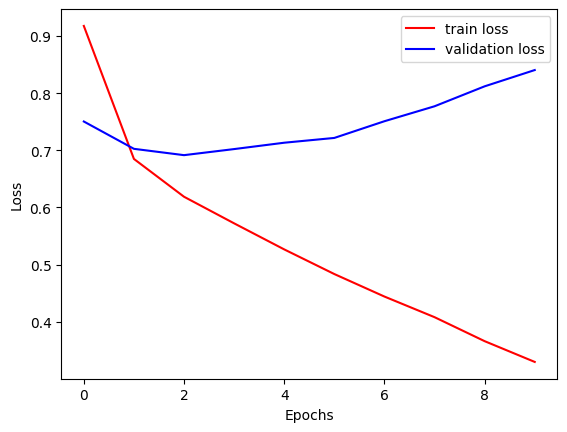

In [ ]:
xrange = np.arange(10)
plt.plot(xrange, model.training_loss, 'r', label='train loss')
plt.plot(xrange, model.validation_loss, 'b', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()